# Illustration of the re-ranking of stereoisomers using LC-MS$^2$Struct

As examples we use three spectra in our MassBank (MB) dataset:

| **Index** | **Spectrum ID** | **MB-subset** | **PubChem ID** | **InChIkey first block (2D)** | **InChIKey second block (3D)** | **Retention time (RT)** | **Precursor type** | **Number of LC-MS experiments** |
| --- | --- | --- | --- | --- | --- | ---: | --- | ---: |
| 1. | BS02391126 | BS_000 | [134751759](https://pubchem.ncbi.nlm.nih.gov/compound/134751759) | NCJNNMWJQIKYLO | FRVSQPBBSA | 7.64 min | [M-H]- | 4 |
| 2. | BS64681001 | BS_000 | [134751760](https://pubchem.ncbi.nlm.nih.gov/compound/134751760) | NCJNNMWJQIKYLO | WYFUIKBSSA | 8.63 min | [M-H]- | 8 | 
| 3. | PR75447353 | PR_002 | [139291977](https://pubchem.ncbi.nlm.nih.gov/compound/139291977) | NCJNNMWJQIKYLO | XCVCLJGOSA | 4.77 min | [M+H]+ | 2 |

The first two spectra are measured under the same LC- and MS-conditions (BS_000) and therefore there RTs are comparable. We can see that there is a significant RT difference of about a minute. In our experimental setup, the candidate sets associated with the three spectra are equal (all share the same molecular formula: C36H32O19). The shared candidate set contains only three candidates: 134751759, 134751760 and 139291977, which are the three stereoisomers sharing the same 2D structure (NCJNNMWJQIKYLO). 

In this notebook we investigate whether LC-MS$^2$Struct can identify the correct stereoisomer for each spectrum. In our evaluation each spectrum can appear in multiple LC-MS experiments (those are generated by sampling from the respective MB-subset). The examples we study here appear between 2 and 8 times in differen LC-MS experiments. The max-marginals used here are produced in conjunctio to the SIRIUS MS$^2$ scorer.

### Isomeric SMILES of the ground truth compounds

| **Index** | **Isomeric SMILES** | 
| --- | --- |
| 1. | ```C1=CC(=CC=C1/C=C/C(=O)O[C@@H]2[C@H]([C@@H]([C@H](O[C@H]2O[C@@H]3[C@H]([C@@H]([C@H](O[C@H]3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O``` | 
| 2. | ```C1=CC(=CC=C1/C=C\C(=O)O[C@@H]2[C@H]([C@@H]([C@H](O[C@H]2O[C@@H]3[C@H]([C@@H]([C@H](O[C@H]3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O``` | 
| 3. | ```C1=CC(=CC=C1/C=C/C(=O)OC2C(C(C(OC2OC3C(C(C(OC3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O``` | 

In [88]:
import sqlite3
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

# RDKIT
from rdkit.Chem import MolFromSmiles, Draw, MolFromInchi, MolToSmiles, AssignStereochemistry, MolFromSmarts
from rdkit.Chem.rdDepictor import Compute2DCoords
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit import __version__ as rdkit__version
print("RDKit:", rdkit__version)
from IPython.display import SVG

# Matchms
from matchms import Spectrum
from matchms import __version__ as matchms__version
print("matchms:", matchms__version)

mb_db_fn = "/home/bach/Documents/doctoral/projects/lcms2struct_experiments/data/massbank.sqlite"
spec_dir = "/home/bach/Documents/doctoral/projects/msms_rt_ssvm_NMI/supplementary_material"

RDKit: 2021.03.1
matchms: 0.9.2


## Load the MS$^2$ spectra

In [59]:
def load_from_peaklist(fn):
    mzs = []
    intensities = []
    with open(fn, "r") as file: 
        for line in file.readlines():
            if len(line.strip()) > 0:
                mz, intensity = line.strip().split("\t")
                mzs.append(float(mz))
                intensities.append(float(intensity))
                
    return Spectrum(np.array(mzs), np.array(intensities))
            
specs = []
    
# BS02391126
specs.append(load_from_peaklist(os.path.join(spec_dir, "BS02391126.peaks")))
specs[-1].set("Precursor type", "[M-H]-")
specs[-1].set("Retention time", 7.64)
specs[-1].set("Spectrum id", "BS02391126")
specs[-1].set("MB-group", "BS_000")
specs[-1].set("inchikey1", "NCJNNMWJQIKYLO")
specs[-1].set("inchikey2", "FRVSQPBBSA")
specs[-1].set("iso_smiles", "C1=CC(=CC=C1/C=C/C(=O)O[C@@H]2[C@H]([C@@H]([C@H](O[C@H]2O[C@@H]3[C@H]([C@@H]([C@H](O[C@H]3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O")


# BS64681001
specs.append(load_from_peaklist(os.path.join(spec_dir, "BS64681001.peaks")))
specs[-1].set("Precursor type", "[M-H]-")
specs[-1].set("Retention time", 8.63)
specs[-1].set("Spectrum id", "BS64681001")
specs[-1].set("MB-group", "BS_000")
specs[-1].set("inchikey1", "NCJNNMWJQIKYLO")
specs[-1].set("inchikey2", "WYFUIKBSSA")
specs[-1].set("iso_smiles", "C1=CC(=CC=C1/C=C\C(=O)O[C@@H]2[C@H]([C@@H]([C@H](O[C@H]2O[C@@H]3[C@H]([C@@H]([C@H](O[C@H]3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O")

# PR75447353
specs.append(load_from_peaklist(os.path.join(spec_dir, "PR75447353.peaks")))
specs[-1].set("Precursor type", "[M+H]+")
specs[-1].set("Retention time", 4.77)
specs[-1].set("Spectrum id", "PR75447353")
specs[-1].set("MB-group", "PR_002")
specs[-1].set("inchikey1", "NCJNNMWJQIKYLO")
specs[-1].set("inchikey2", "XCVCLJGOSA")
specs[-1].set("iso_smiles", "C1=CC(=CC=C1/C=C/C(=O)OC2C(C(C(OC2OC3C(C(C(OC3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O")

### Plot the MS$^2$ spectra

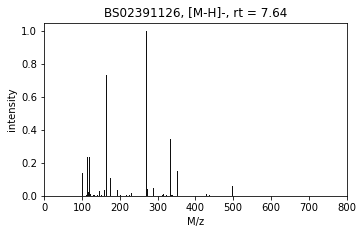

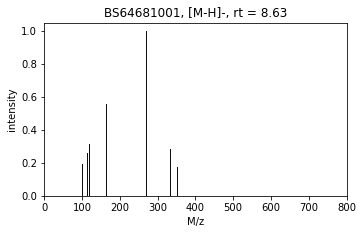

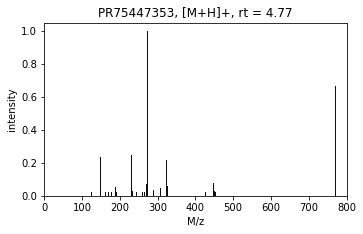

In [57]:
def my_spec_plot(spec, max_mz=None, fig_height=3):
    fig = spec.plot()
    
    # Modify plot
    if max_mz is not None:
        fig.axes[0].set_xlim(0, max_mz)
    fig.set_figheight(fig_height)
    fig.axes[0].set_title("%s, %s, rt = %.2f" % (spec.get("Spectrum id"), spec.get("Precursor type"), spec.get("Retention time")))

    return fig

figs = [my_spec_plot(spec, max_mz=800) for spec in specs]

In [60]:
for ext in ["pdf", "svg"]:
    for spec, fig in zip(specs, figs):
        fig.savefig(os.path.join(".", os.extsep.join(["spectrum__%s" % spec.get("Spectrum id"), ext])))

### Plot the molecular structures

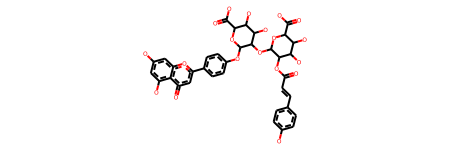

In [95]:
mcs = rdFMCS.FindMCS([MolFromSmiles(spec.get("iso_smiles")) for spec in specs])
patt = MolFromSmarts(mcs.smartsString)
Compute2DCoords(patt)
patt

In [97]:
mcs.smartsString

'[#6]1:[#6]:[#6](:[#6]:[#6]:[#6]:1-[#6]=[#6]-[#6](=[#8])-[#8]-[#6]1-[#6](-[#6](-[#6](-[#8]-[#6]-1-[#8]-[#6]1-[#6](-[#6](-[#6](-[#8]-[#6]-1-[#8]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]1:[#6]:[#6](=[#8]):[#6]2:[#6](:[#8]:1):[#6]:[#6](:[#6]:[#6]:2-[#8])-[#8])-[#6](=[#8])-[#8])-[#8])-[#8])-[#6](=[#8])-[#8])-[#8])-[#8])-[#8]'

In [93]:
for spec in specs:
    mol = MolFromSmiles(spec.get("iso_smiles"))
    Compute2DCoords(mol)
    
    AllChem.AlignMol(mol, patt)
    for ext in ["svg", "png"]:
        Draw.MolToFile(mol, os.path.join(".", os.extsep.join(["molecule__%s" % spec.get("Spectrum id"), ext])))

Load the margins

Find the index corresponding to the spectrum "EA34486399"

In [49]:
idx__2D = [m["spectrum_id"].get("spectrum_id") for m in mm__2D.values()].index("BS57272571")
idx__3D = [m["spectrum_id"].get("spectrum_id") for m in mm__3D.values()].index("BS57272571")
assert idx__2D == idx__3D

Extract the ranked candidate lists for the spectrum.

In [50]:
cands__2D = mm__2D[idx__2D]
cands__3D = mm__3D[idx__3D]

Collect the MS2-scores, Max-margins (2D) and Max-margins (3D) for the stereoisomers corresponding to the ground truth structure ("**KWGRBVOPPLSCSI**-WPRPVWTQSA-N")

In [51]:
conn = sqlite3.connect(mb_db_fn)

ikey = "FJJANLYCZUNFSE-BSKJHSHCSA-N"
ikey1 = ikey.split("-")[0]  # first inchikey part specifying the constitution

assert cands__2D["label"][cands__2D["index_of_correct_structure"]] == ikey
assert cands__3D["label"][cands__3D["index_of_correct_structure"]] == ikey
assert cands__2D["n_cand"] == cands__3D["n_cand"]

df = []
for i in range(cands__2D["n_cand"]):
    if cands__2D["label"][i].split("-")[0] == ikey1:
        assert cands__3D["label"][i].split("-")[0] == ikey1
        assert cands__3D["ms_score"][i] == cands__2D["ms_score"][i]
        
        smi = conn.execute("SELECT smiles_iso FROM molecules WHERE inchikey IS ?", (cands__3D["label"][i], )).fetchone()[0]
        
        df.append([cands__3D["label"][i], cands__3D["label"][i] == ikey, smi, cands__3D["ms_score"][i], cands__2D["score"][i], cands__3D["score"][i]])
        
df = pd.DataFrame(df, columns=["inchikey", "is_true_structure", "smiles", "ms2_score", "max_margin_2D", "max_margin_3D"])

# df 
df.sort_values(by="max_margin_3D", ascending=False)

,inchikey,is_true_structure,smiles,ms2_score,max_margin_2D,max_margin_3D
1,FJJANLYCZUNFSE-QVMKKYBKSA-N,False,CCCCCCCCCCCCCCCCCCCCCC(=O)N[C@H](COP(=O)([O-])...,0.993062,0.999874,0.999898
2,FJJANLYCZUNFSE-BSKJHSHCSA-N,True,CCCCCCCCCCCCCCCCCCCCCC(=O)NC(COP(=O)([O-])OCC[...,0.993062,0.999874,0.999790
0,FJJANLYCZUNFSE-TWKUQIQBSA-N,False,CCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](COP(=O)([O-]...,0.993062,0.999874,0.999508


Filenames of the aggregated margins

In [64]:
fn__2D = "massbank__with_stereo/ds=UT_000__lloss_mode=mol_feat_fps__mol_feat=FCFP__binary__all__2D__mol_id=cid__ms2scorer=metfrag__norm__ssvm_flavor=default/combined__cand_agg_id=inchikey__marg_agg_fun=average/marginals__spl=4.pkl.gz"
fn__3D = "massbank__with_stereo/ds=UT_000__lloss_mode=mol_feat_fps__mol_feat=FCFP__binary__all__3D__mol_id=cid__ms2scorer=metfrag__norm__ssvm_flavor=default/combined__cand_agg_id=inchikey__marg_agg_fun=average/marginals__spl=4.pkl.gz"

Load the margins

In [65]:
with gzip.open(fn__2D) as f:
    mm__2D = pickle.load(f)
    
with gzip.open(fn__3D) as f:
    mm__3D = pickle.load(f)    

Find the index corresponding to the spectrum "EA34486399"

In [66]:
idx__2D = [m["spectrum_id"].get("spectrum_id") for m in mm__2D.values()].index("UT29257495")
idx__3D = [m["spectrum_id"].get("spectrum_id") for m in mm__3D.values()].index("UT29257495")
assert idx__2D == idx__3D

Extract the ranked candidate lists for the spectrum.

In [42]:
cands__2D = mm__2D[idx__2D]
cands__3D = mm__3D[idx__3D]

Collect the MS2-scores, Max-margins (2D) and Max-margins (3D) for the stereoisomers corresponding to the ground truth structure ("**KWGRBVOPPLSCSI**-WPRPVWTQSA-N")

In [67]:
conn = sqlite3.connect(mb_db_fn)

ikey = "FJJANLYCZUNFSE-QVMKKYBKSA-N"
ikey1 = ikey.split("-")[0]  # first inchikey part specifying the constitution

assert cands__2D["label"][cands__2D["index_of_correct_structure"]] == ikey
assert cands__3D["label"][cands__3D["index_of_correct_structure"]] == ikey
assert cands__2D["n_cand"] == cands__3D["n_cand"]

df = []
for i in range(cands__2D["n_cand"]):
    if cands__2D["label"][i].split("-")[0] == ikey1:
        assert cands__3D["label"][i].split("-")[0] == ikey1
        assert cands__3D["ms_score"][i] == cands__2D["ms_score"][i]
        
        smi = conn.execute("SELECT smiles_iso FROM molecules WHERE inchikey IS ?", (cands__3D["label"][i], )).fetchone()[0]
        
        df.append([cands__3D["label"][i], cands__3D["label"][i] == ikey, smi, cands__3D["ms_score"][i], cands__2D["score"][i], cands__3D["score"][i]])
        
df = pd.DataFrame(df, columns=["inchikey", "is_true_structure", "smiles", "ms2_score", "max_margin_2D", "max_margin_3D"])

# df 
df.sort_values(by="max_margin_3D", ascending=False)

,inchikey,is_true_structure,smiles,ms2_score,max_margin_2D,max_margin_3D
1,FJJANLYCZUNFSE-QVMKKYBKSA-N,True,CCCCCCCCCCCCCCCCCCCCCC(=O)N[C@H](COP(=O)([O-])...,0.990578,0.999991,0.999875
2,FJJANLYCZUNFSE-BSKJHSHCSA-N,False,CCCCCCCCCCCCCCCCCCCCCC(=O)NC(COP(=O)([O-])OCC[...,0.990578,0.999991,0.999856
0,FJJANLYCZUNFSE-TWKUQIQBSA-N,False,CCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](COP(=O)([O-]...,0.990578,0.999991,0.999570


In [9]:
df["max_margin_3D"].rank(ascending=False)

0     47.0
1      4.0
2     17.0
3      1.0
4      2.0
      ... 
58    45.0
59    42.0
60     3.0
61    37.0
62    26.0
Name: max_margin_3D, Length: 63, dtype: float64

In [70]:
np.interp(df["max_margin_3D"].rank(ascending=False).tolist(), [1, 9], [100, 0])

array([100. ,  87.5,   0. ,  75. ,  62.5,  37.5,  25. ,  50. ,  12.5])

In [75]:
df["max_margin_3D"].tolist()

[0.9999859643301088,
 0.9999646718409649,
 0.9997665641346509,
 0.9999418072940719,
 0.9999210224428492,
 0.999871391692774,
 0.9998547021478237,
 0.9998788251402316,
 0.9998276311213614]

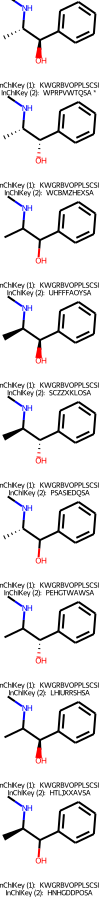

In [83]:
# Draw.MolDrawing(MolFromSmiles("CC([C@H](C1=CC=CC=C1)O)NC"))

legends = []
for _, row in df.iterrows():
    # l = "InChIKey (1): %s\nInChIKey (2): %s" % (__s for __s in row["inchikey"].split("-")[:2])
    l = "InChIKey (1):\t%s\nInChIKey (2):\t%s" % (row["inchikey"].split("-")[0], row["inchikey"].split("-")[1])
    
    legends.append(l)
    if row["is_true_structure"]:
        legends[-1] += " *"
        
mols = [MolFromSmiles(s) for s in df["smiles"]]
_ = [Compute2DCoords(mol) for mol in mols]

Draw.MolsToGridImage(
    mols, 
    molsPerRow=1, 
    subImgSize=(100, 100),
    useSVG=True,
    legends=legends
)

In [77]:
MolToSmiles(MolFromInchi("InChI=1S/C10H15NO/c1-8(11-2)10(12)9-6-4-3-5-7-9/h3-8,10-12H,1-2H3/t8-,10-/m0/s1"))

'CN[C@@H](C)[C@H](O)c1ccccc1'

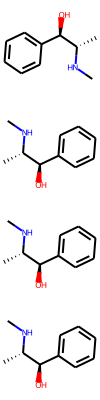

In [90]:
Draw.MolsToGridImage(
    [
        MolFromInchi("InChI=1S/C10H15NO/c1-8(11-2)10(12)9-6-4-3-5-7-9/h3-8,10-12H,1-2H3/t8-,10-/m0/s1"),
        MolFromSmiles("C[C@@H]([C@@H](C1=CC=CC=C1)O)NC", sanitize=True),
        MolFromSmiles("CN[C@@H](C)[C@H](O)C1=CC=CC=C1", sanitize=True),
        MolFromSmiles("c1([C@H]([C@@H](NC)C)O)ccccc1")
    ], 
    molsPerRow=1, 
    subImgSize=(100, 100),
    useSVG=True,
)

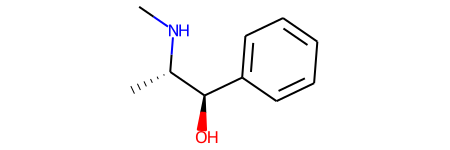

In [116]:
MolFromSmiles("C[C@@H]([C@@H](C1=CC=CC=C1)O)NC")

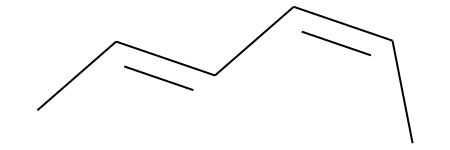

In [102]:
m = MolFromSmiles("C/C=C/C=C\\C")
Compute2DCoords(m)
AssignStereochemistry(m, False, True, True)
m

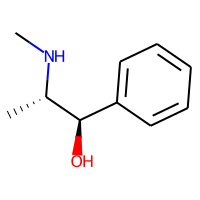

In [128]:
mol = MolFromSmiles("CN[C@@H](C)[C@H](O)C1=CC=CC=C1")
Compute2DCoords(mol)
d2d = rdMolDraw2D.MolDraw2DSVG(200, 200)
d2d.DrawMolecule(mol)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())